# Формальные степенные ряды

Каждый ряд $f(x)$ -- это бесконечная последовательность коэффициентов. То есть ряд
$$
f(x) = f_0 + f_1 x + f_2 x^2 + f_3 x^3 + ...
$$
есть последовательность
$$
[f_0, f_1, f_2, f_3, ...].
$$

Последовательность мы представляем как структуру, часть вычислений которой отложенные. Так описанная выше последовательность есть `Cons(f_0, Cons(f_1, Cons(f_2, Cons(f_3, Thunk))))`. Первые четыре элемента вычислены, а для вычисления пятого надо вызвать функцию, которая этот пятый элемент посчитает.

Cons-ячейка -- это пара, которая даёт информацию о том, каково значение текущего коэффициента, и как вычислить значения всех остальных коэффициентов.

In [1]:
import Base: show, +, *, /, -
using Latexify

In [2]:
"Объединяем две разные структуры под одним типом"
abstract type Series{T <: Number}
end


"Thunk -- это обёртка, отложенное вычисление. Функция, которая вернёт Cons-ячейку при вычислении"
struct Thunk{T <: Number} <: Series{T}
    thunk::Function
end


"Cons-ячейка -- это значение текущего коэффициента и ссылка на оставшийся хвост"
mutable struct Cons{T <: Number} <: Series{T}
    head::T
    tail::Series{T}
    
    function Cons{T}(head::T, tail::Thunk{T}) where T <: Number
        series = new()
        series.head = head
        series.tail = Thunk{T}(() -> series.tail = tail.thunk())  # !
        return series
    end
    
    function Cons{T}(head::T, tail::Cons{T}) where T <: Number
        return new(head, tail)
    end
end


function consthunk(head::T, tail::Function)::Cons{T} where T <: Number
    return Cons{T}(head, Thunk{T}(tail))
end

consthunk (generic function with 1 method)

In [3]:
"Деструктор. Cons-ячейку мы просто раскладвыаем в пару, а Thunk сперва вычисляем, только потом раскладываем"
function peel end

function peel(s::Cons{T})::Tuple{T,Series{T}} where T <: Number
    return (s.head, s.tail)
end

function peel(s::Thunk{T}) where T <: Number
    return peel(s.thunk())
end


"Вспомогательная функция, чтобы не писть много скобок, когда надо сделать Cons(a, Thunk(b))"
function consthunk(head::T, tail::Function)::Series{T} where T <: Number
    return Cons{T}(head, Thunk{T}(tail))
end

consthunk

In [4]:
"Конструктор степенного ряда из генерирующей функции"
function generate(::Type{T}, gen::Function)::Series{T} where T <: Number
    function run(i::Int)::Series{T}
        return consthunk(T(gen(i)), () -> run(i + 1))
    end
    
    return run(0)
end

"Конструктор степенного ряда из вектора"
function series(data::Vector{T}; cycled::Bool=false)::Series{T} where T <: Number
    n = length(data)
    if cycled
        return generate(T, i -> data[i % n + 1], 0)
    else
        return generate(T, i -> (i >= n) ? T(0) : data[i + 1])
    end
end

series

In [5]:
"Взять первые n коэффициентов и вернуть их в векторе"
function take(s::Series{T}, n::Int)::Vector{T} where T <: Number
    vec = Vector{T}(undef, n)
    
    for i in 1:n
        (vec[i], s) = peel(s)
    end
    
    return vec
end

take

In [6]:
"Преобразовать часть степенного ряда в выражение"
function series_expr(s::Series{T}, n::Int=9, var::Symbol=:x)::Expr where T <: Number
    (constant, s) = peel(s)
    args = Any[constant]
    for i in 1:n
        (coef, s) = peel(s)
        term = (i == 1) ? var : :($var ^ $i)
        term = (coef == 1) ? term : :($coef * $term)
        push!(args, term)
    end
    return Expr(:call, :+, args..., :...)
end

"Красивое представление степенного ряда в LaTeX"
function show(io::IO, ::MIME"text/latex", s::Series{T})::Nothing where T <: Number
    println(io, latexify(series_expr(s)))
end

"Красивое представление степенного ряда в LaTeX"
function show(io::IO, ::MIME"text/plain", s::Series{T})::Nothing where T <: Number
    println(io, latexify(series_expr(s)))
end

Base.show

Далее ряды будем представлять следующим образом:
$$
f(x) = f_0 + f_1 x + f_2 x^2 + \ldots = f_h + x \cdot f_t(x),
$$

где $f_h = f_0$ есть "голова"(head), а $f_t(x) = f_1 + f_2 x + f_3 x^2 + \ldots$ есть "хвост"(tail)

### Сложение степенных рядов
Пусть есть ряды $f(x) = f_h + x \cdot f_t(x)$ и $g(x) = g_h + x \cdot g_t(x)$, тогда:

$$
f(x) + g(x) = \left(f_h + g_h\right) + x \cdot \left(f_t(x) + g_t(x)\right)
$$

In [7]:
function +(s1::Series{T}, s2::Series{T})::Series{T} where T <: Number
    (h1, t1) = peel(s1)
    (h2, t2) = peel(s2)
    return consthunk(h1 + h2, () -> t1 + t2)
end

+ (generic function with 191 methods)

### Умножение ряда на число
Пусть есть число $a$ и ряд $f(x) = f_h + x \cdot f_t(x)$, тогда:

$$
a \cdot f(x) = \left(a \cdot f_h \right) + x \cdot \left(a \cdot f_t(x)\right)
$$

In [8]:
function *(a::T, f::Series{T})::Series{T} where T <: Number
    (h, t) = peel(f)
    return consthunk(a * h, () -> a * t)
end

* (generic function with 329 methods)

In [9]:
function -(s::Series{T})::Series{T} where T <: Number
    return T(-1) * s
end

- (generic function with 198 methods)

### Умножение рядов

Пусть есть ряды $f(x) = f_h + x f_t(x)$ и $g(x)$, тогда:

$$
f(x) \cdot g(x) = \left(f_h \cdot g(x)\right) + x \cdot \left(f_t(x) \cdot g(x)\right)
$$

In [10]:
function *(f::Series{T}, g::Series{T})::Series{T} where T <: Number
    (fh, ft) = peel(f)
    return fh * g + consthunk(T(0), () -> ft * g)
end

* (generic function with 330 methods)

### Подстановка
Пусть есть ряды $f(x) = f_h + x f_t(x)$ и $g(x) = x g_t(x)$, тогда:

$$
f(g(x)) = f_h + g(x) \cdot f_t(g(x)) = f_h + x \cdot g_t(x) \cdot f_t(g(x))
$$

Наличие $x$ во втором слагаемом даёт возможность отложить вычисление этого второго слагаемого.

In [11]:
function (f::Series{T})(g::Series{T})::Series{T} where T <: Number
    (gh, gt) = peel(g)
    gh == 0 || throw(ErrorException("non-zero head in application"))

    (fh, ft) = peel(f)
    return consthunk(fh, () -> gt * ft(g))
end

### Обращение ряда (в смысле деления)

Пусть есть ряд $f(x) = f_h + x \cdot f_t(x)$, тогда:

$$
\frac{1}{f(x)} = \frac{1}{f_h + x \cdot f_t(x)} = \frac{1}{f_h} \cdot \frac{1}{1 + x \frac{f_t(x)}{f_h}}
= \frac{1}{f_h} \cdot r\left(-x \frac{f_t(x)}{f_h}\right),
$$
где $r(x) = 1 + x + x^2 + x^3 + \ldots$

In [12]:
"Обращение ряда (в смысле деления)"
function recip(s::Series{T})::Series{T} where T <: Number
    (h, t) = peel(s)
    h == 0 && throw(ErrorException("zero head in reciprocation"))

    ones = generate(T, i -> T(1))
    rh = 1 / h
    return rh * ones(Cons{T}(T(0), -rh * t))
end

recip

### Деление рядов

$$
\frac{f(x)}{g(x)} = f(x) \cdot \frac{1}{g(x)}
$$

In [13]:
function /(s1::Series{T}, s2::Series{T})::Series{T} where T <: Number
    (s2h, s2t) = peel(s2)
    if s2h == 0
        (s1h, s1t) = peel(s1)
        s1h == 0 || throw(ErrorException("zero head in reciprocation"))
        return s1t / s2t
    else
        return s1 * recip(s2)
    end
end

/ (generic function with 107 methods)

In [14]:
"Решить уравнение f(g(x)) = h(x)"
function solve(g::Series{T}, h::Series{T}=series(T[0, 1])) where T <: Number
    (ghead, gtail) = peel(g)
    ghead == 0 || throw(ErrorException("non-zero head of argument in solve"))
    
    (hhead, htail) = peel(h)
    return consthunk(hhead, () -> solve(g, htail / gtail))
end

solve

In [15]:
"Обращение ряда (в смысле подстановки)"
function inv(g::Series{T})::Series{T} where T <: Number
    return solve(g)
end

inv

In [16]:
"Дифференцирование"
function differentiate(s::Series{T})::Series{T} where T <: Number
    function run(s::Series{T}, i::Int)::Series{T}
        (head, tail) = peel(s)
        return consthunk(head * i, () -> run(tail, i + 1))
    end

    (_, tail) = peel(s)
    return run(tail, 1)
end

differentiate

In [17]:
"Интегрирование"
function integrate(s::Series{T}, initial::T=T(0))::Series{T} where T <: Number
    function run(s::Series{T}, i::Int)::Series{T}
        (head, tail) = peel(s)
        return consthunk(head / i, () -> run(tail, i + 1))
    end

    return consthunk(initial, () -> run(s, 1))
end

integrate

In [18]:
ser0 = generate(Rational{Int}, i -> i == 2 ? -1 : 0)

$0 + 0 \cdot x -1 \cdot x^{2} + 0 \cdot x^{3} + 0 \cdot x^{4} + 0 \cdot x^{5} + 0 \cdot x^{6} + 0 \cdot x^{7} + 0 \cdot x^{8} + 0 \cdot x^{9} + ...$


In [19]:
ser1 = generate(Rational{Int}, i -> 1//1)

$1 + x + x^{2} + x^{3} + x^{4} + x^{5} + x^{6} + x^{7} + x^{8} + x^{9} + ...$


In [20]:
recip(ser1)

$1 -1 \cdot x + 0 \cdot x^{2} + 0 \cdot x^{3} + 0 \cdot x^{4} + 0 \cdot x^{5} + 0 \cdot x^{6} + 0 \cdot x^{7} + 0 \cdot x^{8} + 0 \cdot x^{9} + ...$


In [21]:
ser1 / ser1

$1 + 0 \cdot x + 0 \cdot x^{2} + 0 \cdot x^{3} + 0 \cdot x^{4} + 0 \cdot x^{5} + 0 \cdot x^{6} + 0 \cdot x^{7} + 0 \cdot x^{8} + 0 \cdot x^{9} + ...$


In [22]:
ser1(ser0)

$1 + 0 \cdot x -1 \cdot x^{2} + 0 \cdot x^{3} + x^{4} + 0 \cdot x^{5} -1 \cdot x^{6} + 0 \cdot x^{7} + x^{8} + 0 \cdot x^{9} + ...$


In [23]:
ser2 = generate(Rational{Int}, i -> (i == 0) ? 0 : (-1)^i // i)

$0 -1 \cdot x + \frac{1}{2} \cdot x^{2} + \frac{-1}{3} \cdot x^{3} + \frac{1}{4} \cdot x^{4} + \frac{-1}{5} \cdot x^{5} + \frac{1}{6} \cdot x^{6} + \frac{-1}{7} \cdot x^{7} + \frac{1}{8} \cdot x^{8} + \frac{-1}{9} \cdot x^{9} + ...$


In [24]:
ser2 / ser2

$1 + 0 \cdot x + 0 \cdot x^{2} + 0 \cdot x^{3} + 0 \cdot x^{4} + 0 \cdot x^{5} + 0 \cdot x^{6} + 0 \cdot x^{7} + 0 \cdot x^{8} + 0 \cdot x^{9} + ...$


In [25]:
ser1 + ser2

$1 + 0 \cdot x + \frac{3}{2} \cdot x^{2} + \frac{2}{3} \cdot x^{3} + \frac{5}{4} \cdot x^{4} + \frac{4}{5} \cdot x^{5} + \frac{7}{6} \cdot x^{6} + \frac{6}{7} \cdot x^{7} + \frac{9}{8} \cdot x^{8} + \frac{8}{9} \cdot x^{9} + ...$


In [26]:
3//1 * ser1 * ser1

$3 + 6 \cdot x + 9 \cdot x^{2} + 12 \cdot x^{3} + 15 \cdot x^{4} + 18 \cdot x^{5} + 21 \cdot x^{6} + 24 \cdot x^{7} + 27 \cdot x^{8} + 30 \cdot x^{9} + ...$


In [27]:
ser1(ser2)

$1 -1 \cdot x + \frac{3}{2} \cdot x^{2} + \frac{-7}{3} \cdot x^{3} + \frac{11}{3} \cdot x^{4} + \frac{-347}{60} \cdot x^{5} + \frac{3289}{360} \cdot x^{6} + \frac{-1011}{70} \cdot x^{7} + \frac{38371}{1680} \cdot x^{8} + \frac{-136553}{3780} \cdot x^{9} + ...$


In [28]:
differentiate(ser1)

$1 + 2 \cdot x + 3 \cdot x^{2} + 4 \cdot x^{3} + 5 \cdot x^{4} + 6 \cdot x^{5} + 7 \cdot x^{6} + 8 \cdot x^{7} + 9 \cdot x^{8} + 10 \cdot x^{9} + ...$


In [29]:
integrate(ser1)

$0 + x + \frac{1}{2} \cdot x^{2} + \frac{1}{3} \cdot x^{3} + \frac{1}{4} \cdot x^{4} + \frac{1}{5} \cdot x^{5} + \frac{1}{6} \cdot x^{6} + \frac{1}{7} \cdot x^{7} + \frac{1}{8} \cdot x^{8} + \frac{1}{9} \cdot x^{9} + ...$


In [30]:
@time display(inv(inv(inv(inv(inv(inv(ser2)))))))

$0 -1 \cdot x + \frac{1}{2} \cdot x^{2} + \frac{-1}{3} \cdot x^{3} + \frac{1}{4} \cdot x^{4} + \frac{-1}{5} \cdot x^{5} + \frac{1}{6} \cdot x^{6} + \frac{-1}{7} \cdot x^{7} + \frac{1}{8} \cdot x^{8} + \frac{-1}{9} \cdot x^{9} + ...$


  0.776836 seconds (1.95 M allocations: 93.793 MiB, 3.88% gc time, 94.11% compilation time)


In [18]:
mutable struct FixSeries{T <: Number} <: Series{T}
    fun::Union{Function, Series{T}}

    function FixSeries{T}(fun::Function) where T <: Number
        return new(s -> s.fun = fun(s))
    end
end


function peel(s::FixSeries{T})::Tuple{T, Series{T}} where T <: Number
    return peel(isa(s.fun, Function) ? s.fun(s) : s.fun)
end

peel (generic function with 3 methods)

In [21]:
FixSeries{Rational{Int}}(s -> integrate(s, 1//1))

$1 + x + \frac{1}{2} \cdot x^{2} + \frac{1}{6} \cdot x^{3} + \frac{1}{24} \cdot x^{4} + \frac{1}{120} \cdot x^{5} + \frac{1}{720} \cdot x^{6} + \frac{1}{5040} \cdot x^{7} + \frac{1}{40320} \cdot x^{8} + \frac{1}{362880} \cdot x^{9} + ...$


In [19]:
FixSeries{Rational{Int}}(s -> -integrate(integrate(s), -1//1))

$1 + 0 \cdot x + \frac{-1}{2} \cdot x^{2} + 0 \cdot x^{3} + \frac{1}{24} \cdot x^{4} + 0 \cdot x^{5} + \frac{-1}{720} \cdot x^{6} + 0 \cdot x^{7} + \frac{1}{40320} \cdot x^{8} + 0 \cdot x^{9} + ...$


In [32]:
genexp() = integrate(Thunk{Rational{Int}}(() -> genexp()), 1//1)
genexp()

$1 + x + \frac{1}{2} \cdot x^{2} + \frac{1}{6} \cdot x^{3} + \frac{1}{24} \cdot x^{4} + \frac{1}{120} \cdot x^{5} + \frac{1}{720} \cdot x^{6} + \frac{1}{5040} \cdot x^{7} + \frac{1}{40320} \cdot x^{8} + \frac{1}{362880} \cdot x^{9} + ...$


In [35]:
gencos() = -integrate(integrate(Thunk{Rational{Int}}(() -> gencos())), -1//1)
gencos()

$1 + 0 \cdot x + \frac{-1}{2} \cdot x^{2} + 0 \cdot x^{3} + \frac{1}{24} \cdot x^{4} + 0 \cdot x^{5} + \frac{-1}{720} \cdot x^{6} + 0 \cdot x^{7} + \frac{1}{40320} \cdot x^{8} + 0 \cdot x^{9} + ...$


In [36]:
gensin() = -integrate(integrate(Thunk{Rational{Int}}(() -> gensin()), -1//1))
gensin()

$0 + x + 0 \cdot x^{2} + \frac{-1}{6} \cdot x^{3} + 0 \cdot x^{4} + \frac{1}{120} \cdot x^{5} + 0 \cdot x^{6} + \frac{-1}{5040} \cdot x^{7} + 0 \cdot x^{8} + \frac{1}{362880} \cdot x^{9} + ...$


In [40]:
function genbessel0(::Type{T})::Series{T} where T <: Number
    step1 = consthunk(T(0), () -> genbessel0(T))
    _, step2 = peel(integrate(step1))
    return -integrate(step2, T(-1))
end

genbessel0(Rational{Int})

$1 + 0 \cdot x + \frac{-1}{4} \cdot x^{2} + 0 \cdot x^{3} + \frac{1}{64} \cdot x^{4} + 0 \cdot x^{5} + \frac{-1}{2304} \cdot x^{6} + 0 \cdot x^{7} + \frac{1}{147456} \cdot x^{8} + 0 \cdot x^{9} + ...$


In [45]:
@eval bessel(x) = $(let expr = series_expr(genbessel0(Float64), 50); pop!(expr.args); expr; end)

bessel (generic function with 1 method)

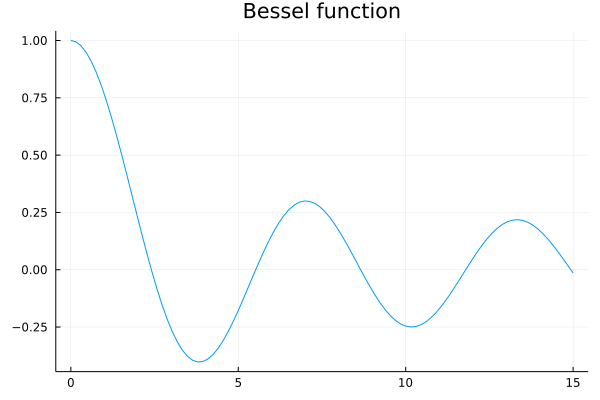

In [46]:
using Plots
xx = LinRange(0, 15, 100)
plot(xx, bessel.(xx), legend=nothing, title="Bessel function")